In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from data.ex_data import get_sea_surface_temp
from statsmodels.stats.diagnostic import acorr_ljungbox

ModuleNotFoundError: No module named 'time_exercises_nf'

### Exercise 6
Simulate and analyze different synthetic signals<br>
• Compare variations of ETS error, trend, seasonality<br>
• Confirm equivalence with ARIMA models when applicable.<br>
• Estimate the model parameters from the generated data.<br>


Model real-world time series<br>
• Compare ETS models with information criteria and residual analysis<br>
• Compare with ARIMA performance using cross-validation<br>
• Compare prediction intervals<br>
• Compare ETS components with decomposition methods<br>

### 1. Synthetic series: 

ETS(A,N,N) AIC: 671.0713599354705
ARIMA(0,1,1) AIC: 667.3004660572744


/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_34366/3661448361.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("2000-01-01", periods=n, freq="M")


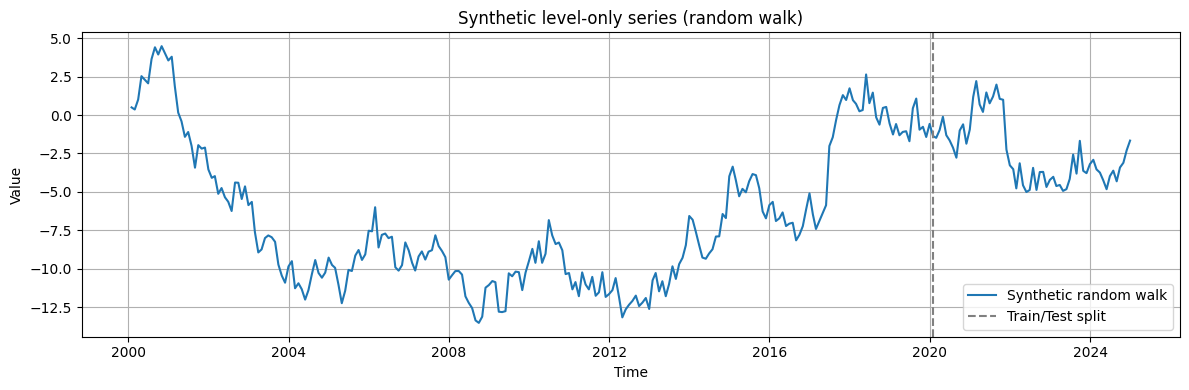

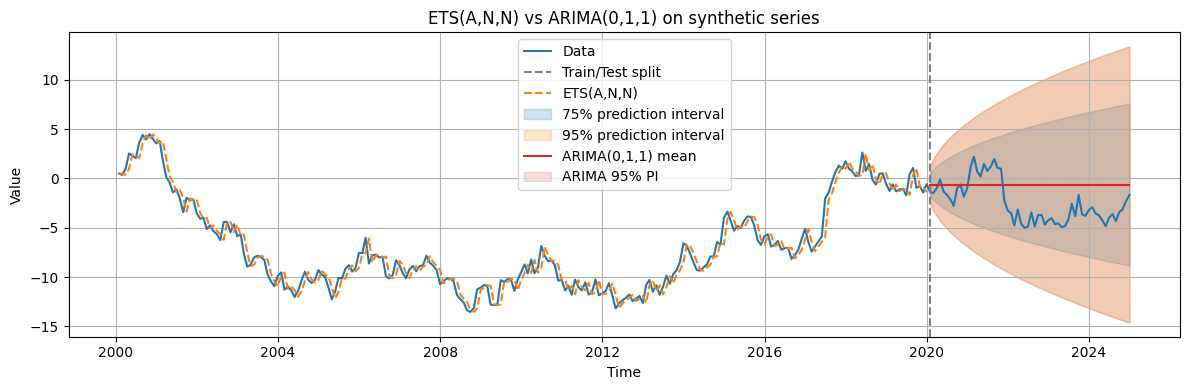

In [ ]:

# 
np.random.seed(42)
n = 300
eps = np.random.normal(scale=1.0, size=n)
y = np.cumsum(eps)  # random walk
idx = pd.date_range("2000-01-01", periods=n, freq="M")
series = pd.Series(y, index=idx)

train_size = int(0.8 * len(series))

fig, ax = time_plot(
    x=series.index,
    y=series,
    label="Synthetic random walk",
    title="Synthetic level-only series (random walk)",
    xlabel="Time",
    ylabel="Value",
    return_fig=True,
)
ax.axvline(series.index[train_size], color="gray", linestyle="--", label="Train/Test split")
ax.legend()
fig.tight_layout()

# ETS(A,N,N)
ets = AutoETS(error="add", trend=None, seasonal=None, auto=False)
ets_fitted, ets_pred, ets_interval = fit_and_forecast(ets, series, train_size)

fig, ax = time_plot(
    x=series.index,
    y=series,
    label="Data",
    title="ETS(A,N,N) vs ARIMA(0,1,1) on synthetic series",
    xlabel="Time",
    ylabel="Value",
    return_fig=True,
)
ax.axvline(series.index[train_size], color="gray", linestyle="--", label="Train/Test split")
plot_fit_and_forecast(ax, ets_fitted, ets_pred, ets_interval, model_name="ETS(A,N,N)")

#ARIMA(0,1,1)
arima_model = ARIMA(series.iloc[:train_size], order=(0, 1, 1)).fit()
arima_forecast = arima_model.get_forecast(steps=len(series) - train_size)
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int(alpha=0.05)

arima_mean.index = series.index[train_size:]
arima_ci.index = series.index[train_size:]

ax.plot(arima_mean.index, arima_mean, label="ARIMA(0,1,1) mean", color="C3")
ax.fill_between(
    arima_ci.index,
    arima_ci.iloc[:, 0],
    arima_ci.iloc[:, 1],
    color="C3",
    alpha=0.15,
    label="ARIMA 95% PI",
)

ax.legend()
fig.tight_layout()

print("ETS(A,N,N) AIC:", ets._fitted_forecaster.aic)
print("ARIMA(0,1,1) AIC:", arima_model.aic)


### Real-world data: Sea surface temperature 

ETS variants
- ETS(A,A,N): additive error, additive trend, no seasonality
- ETS(A,A,A): additive error, additive trend and additive seasonality


/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_34366/831198537.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("2000-01-01", periods=n, freq="M")


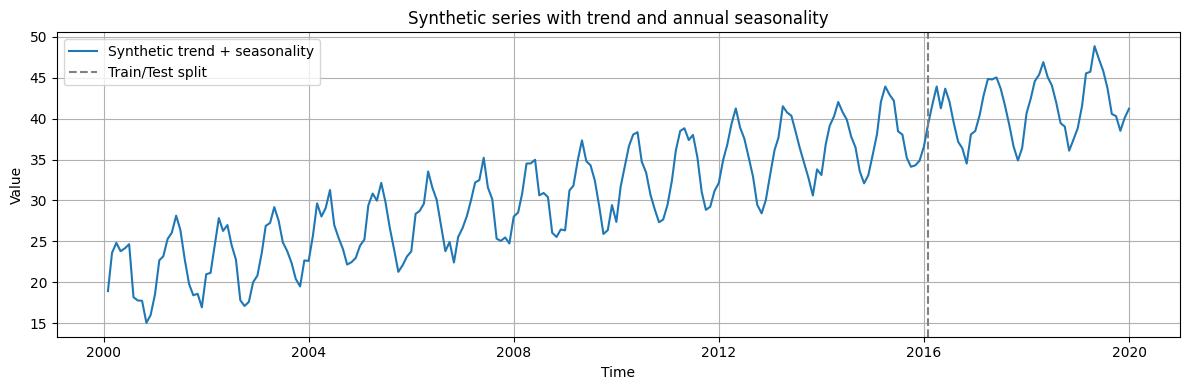

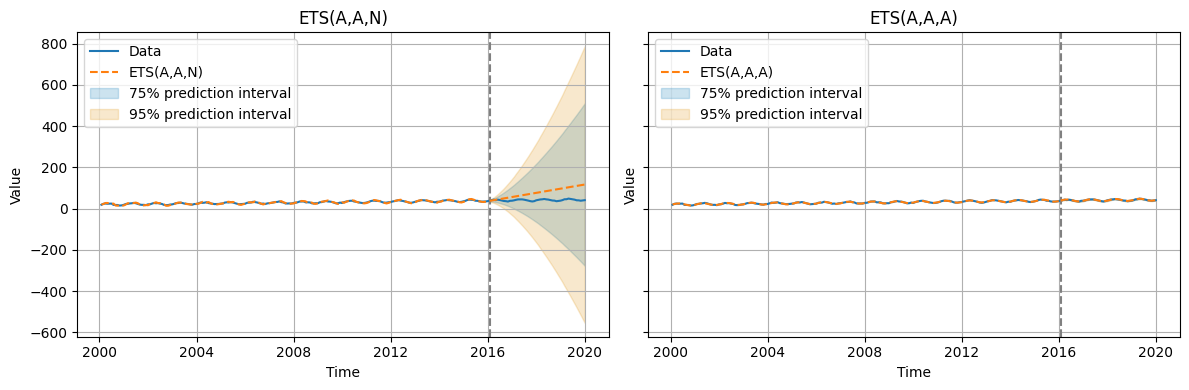

In [ ]:
np.random.seed(123)
n = 240                
t = np.arange(n)
P = 12

trend = 0.1 * t
seasonal_pattern = 5 * np.sin(2 * np.pi * t / P)
noise = np.random.normal(scale=1.0, size=n)

y = 20 + trend + seasonal_pattern + noise
idx = pd.date_range("2000-01-01", periods=n, freq="M")
series_ts = pd.Series(y, index=idx)

train_size = int(0.8 * len(series_ts))

fig, ax = time_plot(
    x=series_ts.index,
    y=series_ts,
    label="Synthetic trend + seasonality",
    title="Synthetic series with trend and annual seasonality",
    xlabel="Time",
    ylabel="Value",
    return_fig=True,
)
ax.axvline(series_ts.index[train_size], color="gray", linestyle="--", label="Train/Test split")
ax.legend()
fig.tight_layout()

fig, axs = get_figure(ncols=2, sharey=True, figsize=(12, 4))

for ax, seasonal in zip(axs, [None, "add"]):
    model_label = f"ETS(A,A,{ 'N' if seasonal is None else 'A'})"
    ets = AutoETS(error="add", trend="add", seasonal=seasonal, sp=12, auto=False)
    fitted, pred, interval = fit_and_forecast(ets, series_ts, train_size)

    time_plot(
        x=series_ts.index,
        y=series_ts,
        label="Data",
        title=model_label,
        xlabel="Time",
        ylabel="Value",
        ax=ax,
    )
    ax.axvline(series_ts.index[train_size], color="gray", linestyle="--")
    plot_fit_and_forecast(ax, fitted, pred, interval, model_name=model_label)
    ax.legend()

fig.tight_layout()


ETS model selection

Model comparison on SST (ETS variants)
Model        AIC        BIC        resid_mean   resid_std   Ljung-Box p(24)
ETS(A,N,N)     2269.3     2283.1       -0.001       1.136           0.000
ETS(A,A,N)     2273.4     2296.3       -0.000       1.136           0.000
ETS(A,A,A)      928.2     1011.0       -0.000       0.445           0.000

Best by AIC: ETS(A,A,A)


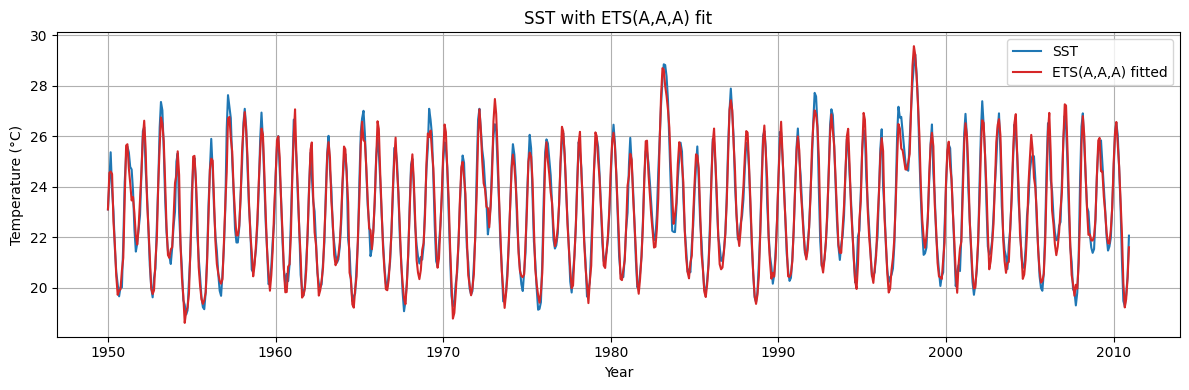

In [ ]:
sst_df = get_sea_surface_temp().set_index("DATE").sort_index()
sst = sst_df["value"].asfreq("MS")


ets_configs = [
    dict(error="add", trend=None,  seasonal=None,  sp=12, label="ETS(A,N,N)"),
    dict(error="add", trend="add", seasonal=None,  sp=12, label="ETS(A,A,N)"),
    dict(error="add", trend="add", seasonal="add", sp=12, label="ETS(A,A,A)"),
]

results = []

for cfg in ets_configs:
    ets = AutoETS(
        error=cfg["error"],
        trend=cfg["trend"],
        seasonal=cfg["seasonal"],
        sp=cfg["sp"],
        auto=False,
    )
    ets.fit(sst)
    fitted = ets._fitted_forecaster
    resid = fitted.resid

    aic = fitted.aic
    bic = fitted.bic
    lb_pvalue = acorr_ljungbox(resid, lags=[24], return_df=True)["lb_pvalue"].iloc[0]

    results.append((cfg["label"], aic, bic, resid.mean(), resid.std(), lb_pvalue))

print("Model comparison on SST (ETS variants)")
print("Model        AIC        BIC        resid_mean   resid_std   Ljung-Box p(24)")
for label, aic, bic, rmean, rstd, pval in results:
    print(f"{label:10s} {aic:10.1f} {bic:10.1f} {rmean:12.3f} {rstd:11.3f} {pval:15.3f}")


best_label, *_ = sorted(results, key=lambda r: r[1])[0]  # lowest AIC
best_cfg = next(c for c in ets_configs if c["label"] == best_label)
print("\nBest by AIC:", best_label)

best_ets = AutoETS(
    error=best_cfg["error"],
    trend=best_cfg["trend"],
    seasonal=best_cfg["seasonal"],
    sp=best_cfg["sp"],
    auto=False,
).fit(sst)
fitted_vals = best_ets._fitted_forecaster.fittedvalues

fig, ax = time_plot(
    x=sst.index,
    y=sst,
    label="SST",
    title=f"SST with {best_label} fit",
    xlabel="Year",
    ylabel="Temperature (°C)",
    return_fig=True,
)
ax.plot(sst.index, fitted_vals, label=f"{best_label} fitted", color="C3")
ax.legend()
fig.tight_layout()


ETS vs ARIMA forecast performance

Rolling 1-step RMSE – ETS: 0.482
Rolling 1-step RMSE – ARIMA: 0.653


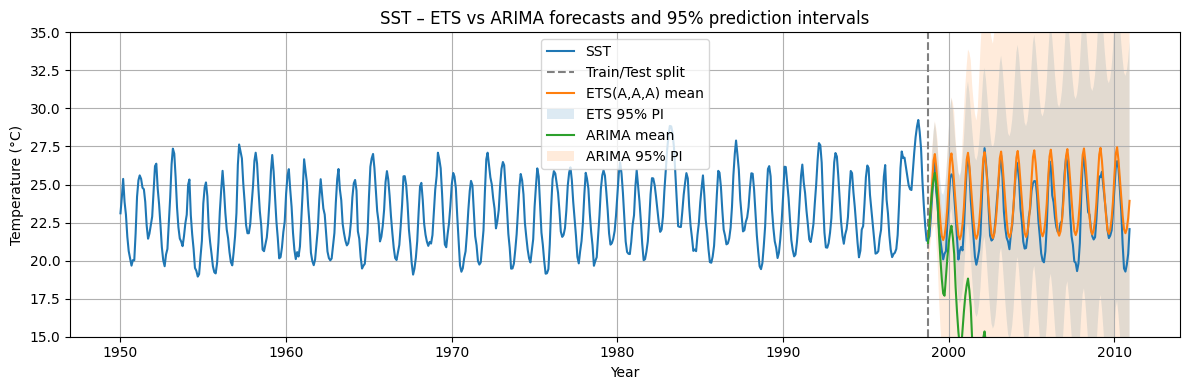

In [ ]:

sst_arima = sst.copy()
if not isinstance(sst_arima.index, pd.DatetimeIndex):
    sst_arima.index = pd.to_datetime(sst_arima.index)
sst_arima.index.freq = 'MS'

sst_ets = sst_arima.to_period("M")


P = 12
order = (0, 1, 1) 
seasonal_order = (0, 1, 0, P) 

def rolling_rmse(series_ets, series_arima, ets_cfg, arima_order, arima_seasonal, initial_train_size):
    errors_ets, errors_arima = [], []
    seasonal_type = ets_cfg.get("seasonal", ets_cfg.get("season", None))

    # rolling window loop
    for end in range(initial_train_size, len(series_ets)):

        # Split data
        train_ets = series_ets.iloc[:end]
        train_arima = series_arima.iloc[:end]
        actual_val = series_arima.iloc[end] 

       
        try:
            model_ets = AutoETS(
                error=ets_cfg["error"],
                trend=ets_cfg["trend"],
                seasonal=seasonal_type,
                sp=ets_cfg["sp"],
                auto=False,
            ).fit(train_ets)
            
            ets_f = model_ets.predict(fh=[1]).iloc[0]
            errors_ets.append(actual_val - ets_f)
        except Exception as e:
            print(f"ETS error at index {end}: {e}")
            continue

        try:
            model_arima = SARIMAX(
                train_arima, 
                order=arima_order, 
                seasonal_order=arima_seasonal,
                enforce_stationarity=False, 
                enforce_invertibility=False
            ).fit(disp=False, maxiter=200)
            arima_f = model_arima.get_forecast(steps=1).predicted_mean.iloc[0]
            errors_arima.append(actual_val - arima_f)
        except Exception as e:
            print(f"ARIMA error at index {end}: {e}")
            continue

    return (
        sqrt(np.mean(np.square(errors_ets))),
        sqrt(np.mean(np.square(errors_arima))),
    )

initial_train = int(0.7 * len(sst_ets))
rmse_ets, rmse_arima = rolling_rmse(
    sst_ets, sst_arima, best_cfg, order, seasonal_order, initial_train
)

print(f"Rolling 1-step RMSE – ETS: {rmse_ets:.3f}")
print(f"Rolling 1-step RMSE – ARIMA: {rmse_arima:.3f}")

train_size = int(0.8 * len(sst))
train_sst_datetime = sst.iloc[:train_size]
test_sst_datetime = sst.iloc[train_size:]

train_sst_period = train_sst_datetime.to_period("M")

seasonal = best_cfg.get("seasonal", best_cfg.get("season", None))

ets_final = AutoETS(
    error=best_cfg["error"],
    trend=best_cfg["trend"],
    seasonal=seasonal,
    sp=best_cfg["sp"],
    auto=False,
).fit(train_sst_period)

# Forecasting
fh = np.arange(1, len(test_sst_datetime) + 1)
ets_forecast = ets_final.predict(fh=fh)
ets_pi = ets_final.predict_interval(fh=fh, coverage=0.95)

train_arima = train_sst_datetime.copy()
train_arima.index.freq = 'MS'

arima_final = SARIMAX(
    train_arima, 
    order=order, 
    seasonal_order=seasonal_order,
    enforce_stationarity=False
).fit(disp=False)

arima_fc = arima_final.get_forecast(steps=len(test_sst_datetime))
arima_mean = arima_fc.predicted_mean
arima_ci = arima_fc.conf_int(alpha=0.05)


fig, ax = time_plot(
    x=sst_arima.index,                  
    y=sst_arima.values,
    label="SST",
    title="SST – ETS vs ARIMA forecasts and 95% prediction intervals",
    xlabel="Year",
    ylabel="Temperature (°C)",
    return_fig=True,
)

ax.axvline(test_sst_datetime.index[0], color="gray", linestyle="--", label="Train/Test split")

ax.plot(test_sst_datetime.index, ets_forecast.values, label=f"{best_label} mean")
ax.fill_between(
    test_sst_datetime.index,
    ets_pi.iloc[:, 0].values, 
    ets_pi.iloc[:, 1].values,
    alpha=0.15,
    label="ETS 95% PI",
)

ax.plot(test_sst_datetime.index, arima_mean.values, label="ARIMA mean")
ax.fill_between(
    test_sst_datetime.index,
    arima_ci.iloc[:, 0].values,
    arima_ci.iloc[:, 1].values,
    alpha=0.15,
    label="ARIMA 95% PI",
)


ax.legend()
ax.set_ylim(15, 35)
fig.tight_layout()